In [1]:
import requests
import json
import pandas as pd
from tqdm import tqdm
import os
from dotenv import load_dotenv

In [2]:
# Riot API Key
# Load environment variables
load_dotenv()

# Retrieve API key from .env
API_KEY = os.getenv("RIOT_API_KEY")

GAME_NAME = "SkywalkerLin"
TAG_LINE = "na1"

# Base URLs for Riot API
ACCOUNT_URL = "https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{gameName}/{tagLine}"
MATCHLIST_URL = "https://americas.api.riotgames.com/tft/match/v1/matches/by-puuid/{puuid}/ids?count={count}"
MATCH_URL = "https://americas.api.riotgames.com/tft/match/v1/matches/{match_id}"

# Function to get Summoner PUUID
def get_summoner_puuid(game_name, tag_line):
    url = ACCOUNT_URL.format(gameName=game_name, tagLine=tag_line) + f"?api_key={API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()["puuid"]
    else:
        print("Error fetching PUUID:", response.json())
        return None

# Function to fetch match IDs
def get_match_ids(puuid, count=5):
    url = MATCHLIST_URL.format(puuid=puuid, count=count) + f"&api_key={API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Error fetching match IDs:", response.json())
        return []

# Function to fetch match details
def get_match_details(match_id):
    url = MATCH_URL.format(match_id=match_id) + f"?api_key={API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Error fetching match details for", match_id, response.json())
        return None

Acquire

In [3]:
# Get PUUID
puuid = get_summoner_puuid(GAME_NAME, TAG_LINE)
if puuid:
    print(f"PUUID for {GAME_NAME}#{TAG_LINE}: {puuid}")
    
    # Get Match IDs
    match_ids = get_match_ids(puuid, count=50)
    print("Match IDs:", match_ids)
    
    # Get Match Details
    match_data_list = []
    for match_id in tqdm(match_ids, desc="Fetching Matches"):
        match_data = get_match_details(match_id)
        if match_data:
            match_data_list.append(match_data)
    
    # Save raw data to JSON file
    with open("tft_matches.json", "w", encoding="utf-8") as f:
        json.dump(match_data_list, f, indent=2)
    
    print("Match data saved to 'tft_matches.json'")
    
    # Convert to Pandas DataFrame for analysis
    df = pd.json_normalize(match_data_list, record_path=['info', 'participants'])
    print(df.head())  # Display first few rows of processed data
else:
    print("Failed to retrieve PUUID. Check API Key and Riot ID.")


PUUID for SkywalkerLin#na1: rC9fkNsc87GwPDWnjQugEwcbmONnmQM7nKHt9O1thwtLKeVjRh4xMta5sUbAhFrmVIU6DVAIqMQJLw
Match IDs: ['NA1_5260355615', 'NA1_5259556512', 'NA1_5259227899', 'NA1_5259196401', 'NA1_5259070220', 'NA1_5259042643', 'NA1_5258921399', 'NA1_5258902324', 'NA1_5258831468', 'NA1_5258822957', 'NA1_5258799365', 'NA1_5258454760', 'NA1_5258415514', 'NA1_5198806071', 'NA1_5198065321', 'NA1_5197757805', 'NA1_5196504135', 'NA1_5196494117', 'NA1_5196482963', 'NA1_5196473708', 'NA1_5196440453', 'NA1_5196431941', 'NA1_5196420951', 'NA1_5195686732', 'NA1_5195671201', 'NA1_5195645746', 'NA1_5195507416', 'NA1_5195473280', 'NA1_5195035694', 'NA1_5195017993', 'NA1_5194997998', 'NA1_5194974452', 'NA1_5194959442', 'NA1_5194903593', 'NA1_5194171646', 'NA1_5194078302', 'NA1_5194043460', 'NA1_5193975545', 'NA1_5193735726', 'NA1_5193409904', 'NA1_5193395346', 'NA1_5193383153', 'NA1_5193363964', 'NA1_5193354810', 'NA1_5193342421', 'NA1_5193335529', 'NA1_5192952432', 'NA1_5192924186', 'NA1_5191696842',

Fetching Matches: 100%|██████████| 50/50 [00:22<00:00,  2.26it/s]

Match data saved to 'tft_matches.json'
   gold_left  last_round  level  placement  players_eliminated  \
0          1          24      8          8                   0   
1          1          24      8          7                   0   
2          4          28      8          6                   0   
3         47          31      8          5                   0   
4         45          33      8          4                   1   

                                               puuid riotIdGameName  \
0  -E45uMGggx3vOTDyHOknqk5WpCIL9M5_8fgi2E3ETtzBGV...          哎呦你干嘛   
1  03TxmgwS2Z7v6szM5XPTsSemWtTByCU1t04yeq9fmYy0N3...    flog nilbog   
2  haxrw5LntpypScQN1t_8FmGAfB6-M0CtkfQqkXtE3fVVjQ...        Phuman2   
3  rC9fkNsc87GwPDWnjQugEwcbmONnmQM7nKHt9O1thwtLKe...   SkywalkerLin   
4  zLXLHSmuSapUIaPhYvGf61Il_wXMm6aVKM4BnmFYRBKLdE...   Shanks A Lot   

  riotIdTagline  time_eliminated  total_damage_to_players  \
0         China      1426.673584                       34   
1          8004

Process / Analyze

In [4]:
# Quality Assessment and Basic Cleaning
from pathlib import Path
import re

RAW_JSON = "tft_matches.json"          # Output from Acquire step
OUT_DIR   = Path("curated")            # Final data folder
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Load raw JSON ----------
with open(RAW_JSON, encoding="utf-8") as f:
    raw = json.load(f)

rows = []
for game in raw:
    meta = game["metadata"]
    info = game["info"]  
    patch_match = re.search(r"\d+\.\d+", info["game_version"])
    base = {
        "match_id":   meta["match_id"],
        "game_time":  pd.to_datetime(info["game_datetime"], unit="ms", utc=True),
        "patch":      patch_match.group() if patch_match else "unknown",
        "queue_id":   info["queue_id"],
    }
    for p in info["participants"]:
        rows.append({
            **base,
            "puuid":       p["puuid"],
            "placement":   p["placement"],
            "level":       p["level"],
            "gold_left":   p["gold_left"],
            "traits_raw":  p["traits"],      # keep nested fields for now
            "units_raw":   p["units"],
        })

df = pd.DataFrame(rows)

# ---------- Basic quality checks ----------
df["status"] = "ok"

# Missing values check
na_mask = df.isna().any(axis=1)
df.loc[na_mask, "status"] = "missing"

# Valid range: placement 1–8, level 1–10
range_mask = ~df["placement"].between(1, 8) | ~df["level"].between(1, 10)
df.loc[range_mask, "status"] = "invalid"

print("QC summary (rows):")
print(df["status"].value_counts())

# ---------- Friendly display: compress traits / units ----------
def traits_to_str(traits):
    return ",".join(f"{t['name']}-{t['tier_current']}" for t in traits)

def units_to_str(units):
    return ",".join(f"{u['character_id'].split('_')[-1]}-{u['tier']}" for u in units)

df["traits"] = df["traits_raw"].apply(traits_to_str)
df["units"]  = df["units_raw"].apply(units_to_str)
df = df.drop(columns=["traits_raw", "units_raw"])

# ---------- Save as CSV ----------
csv_path = OUT_DIR / "tft_matches_flat.csv"
df.to_csv(csv_path, index=False)
print(f"Saved cleaned data to {csv_path.resolve()}")

df.head()  # show first few rows


QC summary (rows):
status
ok    400
Name: count, dtype: int64
Saved cleaned data to /home/ericlin/tft/curated/tft_matches_flat.csv


,match_id,game_time,patch,queue_id,puuid,placement,level,gold_left,status,traits,units
0,NA1_5260355615,2025-04-05 16:02:41.389000+00:00,15.7,1100,-E45uMGggx3vOTDyHOknqk5WpCIL9M5_8fgi2E3ETtzBGV...,8,8,1,ok,"TFT14_Armorclad-1,TFT14_BallisTek-0,TFT14_Brui...","Jax-2,Poppy-2,Jhin-1,Naafiri-1,Varus-1,Mordeka..."
1,NA1_5260355615,2025-04-05 16:02:41.389000+00:00,15.7,1100,03TxmgwS2Z7v6szM5XPTsSemWtTByCU1t04yeq9fmYy0N3...,7,8,1,ok,"TFT14_Armorclad-2,TFT14_Bruiser-0,TFT14_Cutter...","Kindred-1,Jax-1,Shyvana-1,Varus-2,Mordekaiser-..."
2,NA1_5260355615,2025-04-05 16:02:41.389000+00:00,15.7,1100,haxrw5LntpypScQN1t_8FmGAfB6-M0CtkfQqkXtE3fVVjQ...,6,8,4,ok,"TFT14_AnimaSquad-3,TFT14_Armorclad-1,TFT14_Con...","Sylas-2,Vayne-1,Illaoi-1,Yuumi-2,Xayah-2,Leona..."
3,NA1_5260355615,2025-04-05 16:02:41.389000+00:00,15.7,1100,rC9fkNsc87GwPDWnjQugEwcbmONnmQM7nKHt9O1thwtLKe...,5,8,47,ok,"TFT14_AnimaSquad-1,TFT14_Divinicorp-1,TFT14_Ed...","Jhin-2,Rhaast-2,Braum-2,Jarvan-2,Xayah-2,Leona..."
4,NA1_5260355615,2025-04-05 16:02:41.389000+00:00,15.7,1100,zLXLHSmuSapUIaPhYvGf61Il_wXMm6aVKM4BnmFYRBKLdE...,4,8,45,ok,"TFT14_Armorclad-1,TFT14_Bruiser-0,TFT14_EdgeRu...","NidaleeCougar-3,Kindred-3,Shyvana-3,Jhin-3,Naa..."


Total rows: 400 | OK rows: 400


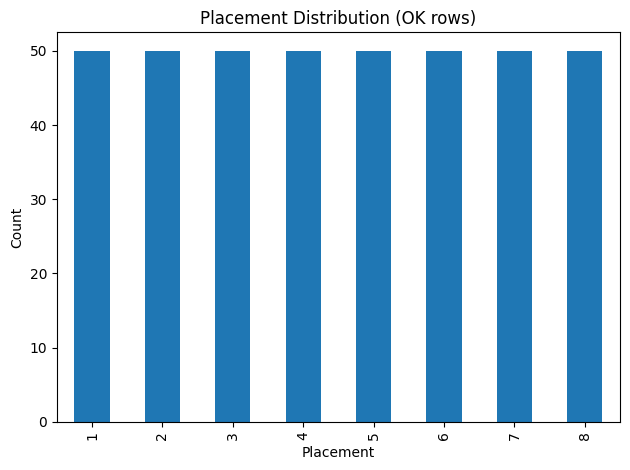

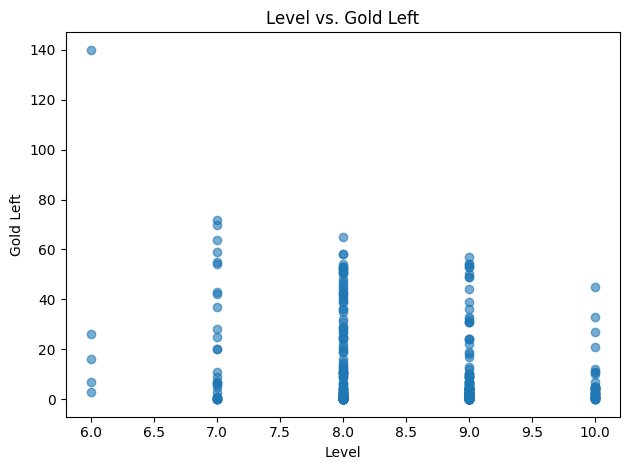

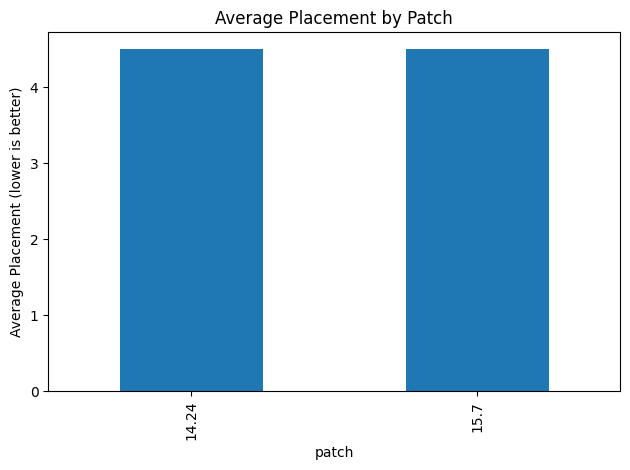


Numeric summary (OK rows):
        placement      level   gold_left
count  400.000000  400.00000  400.000000
mean     4.500000    8.56000   10.782500
std      2.294157    0.82953   17.660405
min      1.000000    6.00000    0.000000
25%      2.750000    8.00000    1.000000
50%      4.500000    9.00000    2.000000
75%      6.250000    9.00000   11.000000
max      8.000000   10.00000  140.000000


In [5]:
# Exploratory Analysis – quick EDA plots
import matplotlib.pyplot as plt

CSV_PATH = "curated/tft_matches_flat.csv"
df = pd.read_csv(CSV_PATH)

df_ok = df[df["status"] == "ok"].copy()
print(f"Total rows: {len(df)} | OK rows: {len(df_ok)}")

# ---------- Placement distribution ----------
plt.figure()
(df_ok["placement"]
     .value_counts()
     .sort_index()
     .plot(kind="bar"))
plt.xlabel("Placement")
plt.ylabel("Count")
plt.title("Placement Distribution (OK rows)")
plt.tight_layout()
plt.show()

# ---------- Level vs. Gold Left ----------
plt.figure()
plt.scatter(df_ok["level"], df_ok["gold_left"], alpha=0.6)
plt.xlabel("Level")
plt.ylabel("Gold Left")
plt.title("Level vs. Gold Left")
plt.tight_layout()
plt.show()

# ---------- Average placement by patch ----------
plt.figure()
(df_ok.groupby("patch")["placement"]
     .mean()
     .plot(kind="bar"))
plt.ylabel("Average Placement (lower is better)")
plt.title("Average Placement by Patch")
plt.tight_layout()
plt.show()

# ---------- Descriptive statistics ----------
summary = df_ok[["placement", "level", "gold_left"]].describe()
print("\nNumeric summary (OK rows):")
print(summary)


In [6]:
# Organize raw JSON into raw/YYYY-MM-DD/patch/<match_id>.json
from datetime import datetime
import re

RAW_FILE = Path("tft_matches.json")
RAW_ROOT = Path("raw")

# ---------- Load and prepare ----------
with open(RAW_FILE, encoding="utf-8") as f:
    matches = json.load(f)

print(f"Loaded {len(matches)} matches.")

# ---------- Extract date & patch, save to folder ----------
for m in matches:
    info = m["info"]
    meta = m["metadata"]

    # Match date
    dt = datetime.utcfromtimestamp(info["game_datetime"] / 1000.0)
    date_str = dt.strftime("%Y-%m-%d")

    # Patch version
    match_patch = re.search(r"\d+\.\d+", info["game_version"])
    patch_str = match_patch.group() if match_patch else "unknown"

    # Target folder: raw/2025-05-11/15.7/
    out_dir = RAW_ROOT / date_str / patch_str
    out_dir.mkdir(parents=True, exist_ok=True)

    # Save as JSON: one file per match
    out_path = out_dir / f"{meta['match_id']}.json"
    with open(out_path, "w", encoding="utf-8") as f_out:
        json.dump(m, f_out, indent=2)

print("✔ Finished organizing raw JSON.")

Loaded 50 matches.
✔ Finished organizing raw JSON.


/tmp/ipykernel_67833/1026764498.py:20: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(info["game_datetime"] / 1000.0)
